Import Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Read in Dataset

In [0]:
#attribute list
col_names = ['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','income']

In [0]:
#reading in the training data and the data to be predicted
adult_data_train=pd.read_csv('adult.data',names=col_names)
adult_data_test= pd.read_csv('adult.test', names=col_names, skiprows=1)

EDA

In [0]:
adult_data_train.head()

In [0]:
adult_data_train.info()

In [0]:
adult_data_train.sex.unique()

In [0]:
adult_data_train.race.unique()

In [0]:
adult_data_train.relationship.unique()

In [43]:
adult_data_train.education.unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [0]:
adult_data_train.workclass.unique()

In [0]:
adult_data_train.occupation.unique()

In [0]:
adult_data_train.income.unique()

In [0]:
adult_data_train.marital_status.unique()

In [0]:
adult_data_train.native_country.unique()

In [0]:
adult_data_train.describe()

Visualisations

In [0]:
sns.countplot(y='occupation', hue='income', data=adult_data_train)

In [0]:
sns.countplot(y='native-country', hue='income', data=adult_data_train)

In [0]:
sns.countplot(y='marital-status', hue='income', data=adult_data_train)

In [0]:
sns.countplot(y='education', hue='income', data=adult_data_train)

# Preprocessing the data

Handle the missing values

In [18]:
#finding out if there are missing values:
adult_data_train.isnull().values.sum()              #total number of missing values

0

The missing values (in the form of "?") occurs in the column "workclass" and "occupation", both containing categorical data. So "?" will be considered as another category. And even if we replace the "?" with some other data, that wont be justified. One way is to drop the rows with the "?" categorical values.

Encoding :

In [19]:
#separating the columns that needs to be encoded
to_be_encoded_train = adult_data_train.select_dtypes(include=['object']).copy()
to_be_encoded_train.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [22]:
#separating the columns that needs to be encoded
to_be_encoded_test = adult_data_test.select_dtypes(include=['object']).copy()
to_be_encoded_test.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K.
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K.
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K.
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K.
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States,<=50K.


In [0]:
#Ecoding the categorical data
label_encoder=LabelEncoder()

In [0]:
train_data_encoded=to_be_encoded_train.apply(label_encoder.fit_transform)
test_data_encoded=to_be_encoded_test.apply(label_encoder.fit_transform)

In [25]:
train_data_encoded.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,7,9,4,1,1,4,1,39,0
1,6,9,2,4,0,4,1,39,0
2,4,11,0,6,1,4,1,39,0
3,4,1,2,6,0,2,1,39,0
4,4,9,2,10,5,2,0,5,0


In [26]:
test_data_encoded.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,4,1,4,7,3,2,1,38,0
1,4,11,2,5,0,4,1,38,0
2,2,7,2,11,0,4,1,38,1
3,4,15,2,7,0,2,1,38,1
4,0,15,4,0,3,4,0,38,0


Standardize scale to prep for KNN Algo

In [0]:
#separating the columns that needs to be standardized
to_be_standardized_train=adult_data_train[['fnlwgt','capital_gain','capital_loss']].copy()
to_be_standardized_test=adult_data_test[['fnlwgt','capital_gain','capital_loss']].copy()

In [0]:
scaler=StandardScaler()

In [0]:
scaler.fit(to_be_standardized_train)
standardized_train=scaler.transform(to_be_standardized_train)

In [0]:
scaler.fit(to_be_standardized_test)
standardized_test=scaler.transform(to_be_standardized_test)

In [0]:
stand_train=pd.DataFrame(standardized_train,columns=['fnlwgt','capital_gain','capital_loss'])
stand_test=pd.DataFrame(standardized_test,columns=['fnlwgt','capital_gain','capital_loss'])

In [41]:
stand_train.head()

,fnlwgt,capital_gain,capital_loss
0,-1.063611,0.148453,-0.21666
1,-1.008707,-0.145920,-0.21666
2,0.245079,-0.145920,-0.21666
3,0.425801,-0.145920,-0.21666
4,1.408176,-0.145920,-0.21666


In [42]:
stand_test.head()

,fnlwgt,capital_gain,capital_loss
0,0.353474,-0.142662,-0.218062
1,-0.942391,-0.142662,-0.218062
2,1.395450,-0.142662,-0.218062
3,-0.275397,0.871091,-0.218062
4,-0.812954,-0.142662,-0.218062


Forming the final dataframes to be fed for training and testing:

In [0]:
X_train=pd.concat([adult_data_train[['age','education_num','hours_per_week']].copy(),stand_train,train_data_encoded.drop(columns='income')],axis=1)
Y_train=train_data_encoded['income']

In [0]:
X_test=pd.concat([adult_data_test[['age','education_num','hours_per_week']].copy(),stand_test,test_data_encoded.drop(columns='income')],axis=1)
Y_test=test_data_encoded['income']

Split into training and test data sets:

Since different datasets are already available for testing and training, train_test_split is not required. 

create and train the model

# The KNN Model

Text(0, 0.5, 'Testing Accuracy')

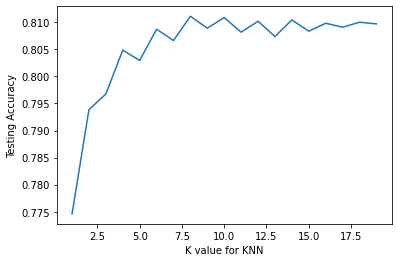

In [51]:
# Find the optimum value of k
k_range=range(1,20)
scores={}
scores_list=[]

for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,Y_train)
    y_pred=knn.predict(X_test)
    sc=metrics.accuracy_score(Y_test,y_pred)
    scores[k]=sc
    scores_list.append(sc)
    
plt.plot(k_range,scores_list)
plt.xlabel('K value for KNN')
plt.ylabel('Testing Accuracy')

Make predictions with the model

Evaluate alternative k values for better prediction

Plot error rate

Adjust K value per error rate evaluations

In [0]:
#Train the knn model with optimum value of k
k_optimum=15
knn=KNeighborsClassifier(n_neighbors=k_optimum)
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.7888837709196991

In [0]:
#predict the value for the test sets
prediction=knn.predict(data_predict)

In [0]:
pred=pd.DataFrame(prediction,columns=['pred'])

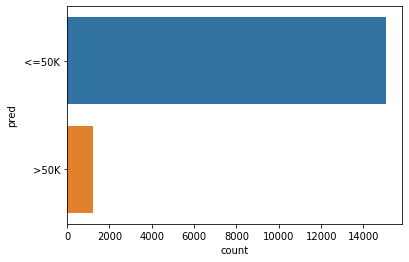

In [0]:
sns.countplot(y='pred',data=pred,)